## Import packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
parent_dir = Path.cwd().parent.parent.parent

"""
This code is used for Fig3. Decadal evolution of population- and facility-based equity of public EV charger system in the U.S. 
"""

'\nThis code is used for Fig3. Decadal evolution of population- and facility-based equity of public EV charger system in the U.S. \n'

## Data Processing

In [2]:
def combine_data_equity(usa_map_gdf, start_year, end_year, evse_name):
    """
    Combine USA map data with equity metrics (Gini coefficients) for multiple years.
    """
    # Initialize final GeoDataFrame
    final_gdf = usa_map_gdf.copy()
    
    # Process data for each year
    for year in range(start_year, end_year + 1):
        # Read equity data file
        acc_file = parent_dir / 'data' / 'US-equity' / 'population-based' / f'{year}' / f'{year}_city_gini_summaries_{evse_name}.csv'
        acc_data = pd.read_csv(acc_file)
        
        # Merge map data with Gini coefficients
        matched_df = pd.merge(usa_map_gdf, acc_data[['GID_2', 'Gini_Coefficient']], on='GID_2', how='inner')
        matched_df = matched_df.rename(columns={'Gini_Coefficient': f'Year{year}'})
        
        # Merge year data into final GeoDataFrame
        final_gdf = pd.merge(final_gdf, matched_df[['GID_2', f'Year{year}']], on='GID_2', how='left')
    
    # Ensure geometry column is preserved and fill missing values
    final_gdf = gpd.GeoDataFrame(final_gdf, geometry='geometry').fillna(2)
    
    print(f"Combined equity data for {end_year - start_year + 1} years ({start_year}-{end_year})")
    print(f"Final shape: {final_gdf.shape}")
    
    return final_gdf


def combine_data_evcs(usa_map_gdf, year, evse_name):
    """
    Process EVCS data for a specific year and aggregate by administrative regions.
    """
    # Read EVCS data file
    evse_file = parent_dir / 'data' / 'US-EV-Station-2014-2024' / f'alt_fuel_stations_historical_day (Dec 31 {year}).geojson'
    usa_evse = gpd.read_file(evse_file)
    
    # Ensure consistent coordinate reference system
    usa_map_gdf = usa_map_gdf.to_crs(epsg=4326)
    usa_evse = usa_evse.to_crs(epsg=4326)
    
    # Perform spatial join to assign EV stations to administrative regions
    joined_data = gpd.sjoin(usa_evse, usa_map_gdf, how="inner", predicate="within")
    
    # Convert EVSE count columns to numeric and calculate totals
    evse_columns = ['ev_dc_fast_num', 'ev_level1_evse_num', 'ev_level2_evse_num']
    for col in evse_columns:
        joined_data[col] = pd.to_numeric(joined_data[col], errors='coerce').fillna(0)
    
    joined_data['evse_num'] = joined_data[evse_columns].sum(axis=1)
    
    # Aggregate data by administrative region
    aggregated_data = joined_data.groupby('GID_2')[evse_name].sum().reset_index()
    aggregated_data = aggregated_data.rename(columns={evse_name: f'Year{year}'})
    
    print(f"Processed EVCS data for {year}: {len(aggregated_data)} regions")
    
    return aggregated_data


def filter_year_data(usa_map_gdf, evse_name, start_year, end_year):
    """
    Combine equity data with EVCS data and filter regions with no EV stations.
    """
    # Load equity data (Gini coefficients)
    final_gdf_all_gini = combine_data_equity(usa_map_gdf, 2014, 2024, evse_name)
    
    # Process each year to filter regions without EV stations
    for year in range(start_year, end_year + 1):
        # Get EVCS data for current year
        evcs_data = combine_data_evcs(usa_map_gdf, year, evse_name)
        
        # Identify regions with EV stations (value != 0)
        regions_with_ev = evcs_data[evcs_data[f'Year{year}'] != 0]['GID_2']
        
        # Mark regions without EV stations as 2
        final_gdf_all_gini.loc[~final_gdf_all_gini['GID_2'].isin(regions_with_ev), f'Year{year}'] = 2
    
    print(f"Filtered data for years {start_year}-{end_year}")
    print(f"Regions with EV stations identified and marked")
    
    return final_gdf_all_gini

In [3]:
# read u.s. boudaries
usa_map_file = parent_dir / 'data' / 'US-map'/ 'usa_map.geojson'
usa_map_gdf = gpd.read_file(usa_map_file)
usa_map_gdf = usa_map_gdf[['GID_0', 'GID_1', 'GID_2', 'COUNTRY', 'NAME_1', 'NAME_2', 'geometry']]

# joining map with equity values
final_gdf_all_gini = combine_data_equity(usa_map_gdf,2014,2024,evse_name='evse_num')
final_gdf_dc_gini = combine_data_equity(usa_map_gdf,2014,2024,evse_name='ev_dc_fast_num')
final_gdf_l1_gini = combine_data_equity(usa_map_gdf,2014,2024,evse_name='ev_level1_evse_num')
final_gdf_l2_gini = combine_data_equity(usa_map_gdf,2014,2024,evse_name='ev_level2_evse_num')

# filter counties with no evcs
final_gdf_all_evse = filter_year_data(usa_map_gdf, 'evse_num',2014,2024)
final_gdf_dc_evse = filter_year_data(usa_map_gdf, 'ev_dc_fast_num',2014,2024)
final_gdf_l1_evse = filter_year_data(usa_map_gdf, 'ev_level1_evse_num',2014,2024)
final_gdf_l2_evse = filter_year_data(usa_map_gdf, 'ev_level2_evse_num',2014,2024)


# filter columns（Year2014 - Year2023）
columns_to_plot = ['Year2014','Year2015','Year2016', 'Year2017', 'Year2018', 'Year2019', 'Year2020', 'Year2021', 'Year2022', 'Year2023', 'Year2023','Year2024']

# tag
final_gdf_all_evse['EVSE_Type'] = 'All EVSE'
final_gdf_dc_evse['EVSE_Type'] = 'DC EVSE'
final_gdf_l1_evse['EVSE_Type'] = 'L1 EVSE'
final_gdf_l2_evse['EVSE_Type'] = 'L2 EVSE'

# long format
def prepare_data(df, evse_type):
    data = df[columns_to_plot + ['EVSE_Type']]
    data_long = data.melt(id_vars=['EVSE_Type'], var_name='Year', value_name='Accessibility')
    data_long_nontwo = data_long[data_long['Accessibility'] != 2]
    return data_long_nontwo

# merge
all_data = pd.concat([
    prepare_data(final_gdf_all_evse, 'All EVSE'),
    prepare_data(final_gdf_l2_evse, 'L2 EVSE'),
    prepare_data(final_gdf_dc_evse, 'DC EVSE'),
    prepare_data(final_gdf_l1_evse, 'L1 EVSE'),
    
])

all_data

Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2014: 952 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2015: 1099 regions
Processed EVCS data for 2016: 1275 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2017: 1364 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2018: 1433 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2019: 1576 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2020: 1727 regions
Processed EVCS data for 2021: 1834 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2022: 1964 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2023: 2126 regions


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2024: 2249 regions
Filtered data for years 2014-2024
Regions with EV stations identified and marked
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2014: 952 regions
Processed EVCS data for 2015: 1099 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2016: 1275 regions
Processed EVCS data for 2017: 1364 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2018: 1433 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2019: 1576 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2020: 1727 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2021: 1834 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2022: 1964 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2023: 2126 regions


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2024: 2249 regions
Filtered data for years 2014-2024
Regions with EV stations identified and marked
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2014: 952 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2015: 1099 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2016: 1275 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2017: 1364 regions
Processed EVCS data for 2018: 1433 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2019: 1576 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2020: 1727 regions
Processed EVCS data for 2021: 1834 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2022: 1964 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2023: 2126 regions


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2024: 2249 regions
Filtered data for years 2014-2024
Regions with EV stations identified and marked
Combined equity data for 11 years (2014-2024)
Final shape: (3148, 18)


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2014: 952 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2015: 1099 regions


Skipping field ev_connector_types: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2016: 1275 regions
Processed EVCS data for 2017: 1364 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2018: 1433 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2019: 1576 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2020: 1727 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2021: 1834 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2022: 1964 regions


Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2023: 2126 regions


Skipping field funding_sources: unsupported OGR type: 5
Skipping field ev_connector_types: unsupported OGR type: 5


Processed EVCS data for 2024: 2249 regions
Filtered data for years 2014-2024
Regions with EV stations identified and marked


,EVSE_Type,Year,Accessibility
1,All EVSE,Year2014,0.994985
7,All EVSE,Year2014,0.994698
10,All EVSE,Year2014,0.998736
15,All EVSE,Year2014,0.988939
19,All EVSE,Year2014,0.993396
...,...,...,...
37729,L1 EVSE,Year2024,0.999714
37730,L1 EVSE,Year2024,0.992664
37733,L1 EVSE,Year2024,0.917942
37740,L1 EVSE,Year2024,0.998001


## Visualization - Fig.3.A

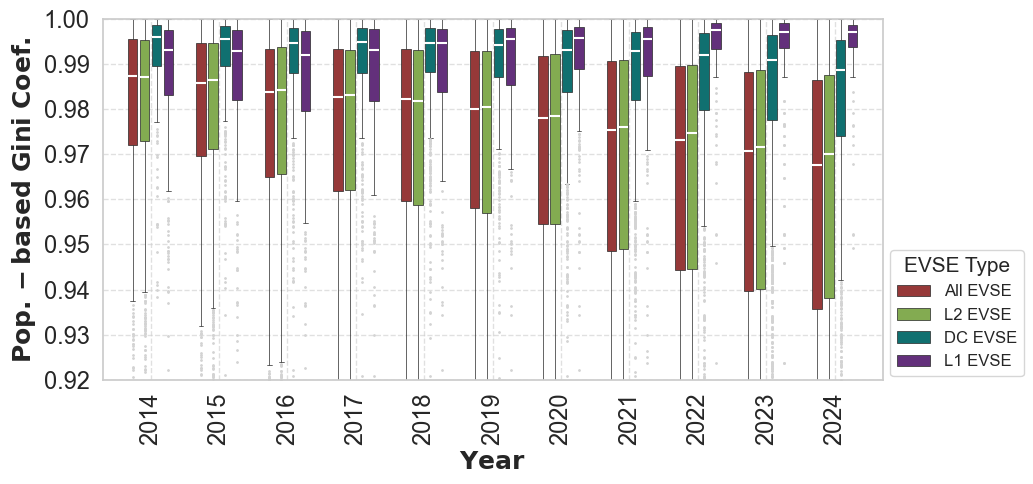

In [4]:
def plot_gini_boxplot(all_data, figsize=(10.5, 5)):
    """
    Create a boxplot showing Gini coefficient distribution by year and EVSE type.
    """
    # Set Seaborn theme and style
    sns.set_theme(style="whitegrid", palette="Set2")
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Define custom color palette
    custom_palette = ["brown", "#84BA42", "teal", "#682487"]
    
    # Create boxplot
    sns.boxplot(
        x='Year', 
        y='Accessibility', 
        hue='EVSE_Type',
        data=all_data, 
        palette=custom_palette,
        width=0.7,
        linewidth=0.5,
        dodge=True,
        gap=0.2,
        flierprops={
            'marker': 'o',
            'markerfacecolor': 'lightgrey',
            'markeredgecolor': 'lightgrey',
            'markersize': 1
        },
        medianprops={'color': 'white', 'linewidth': 1.5},
        ax=ax
    )
    
    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Set axis labels
    ax.set_xlabel(r'$\bf{Year}$', fontsize=18)
    ax.set_ylabel(r'$\bf{Pop.-based\ Gini\ Coef.}$', fontsize=18, linespacing=1.8)
    
    # Format x-axis tick labels
    ax.set_xticklabels([tick.get_text().replace('Year', '') for tick in ax.get_xticklabels()])
    plt.xticks(rotation=90, fontsize=17)
    plt.yticks(fontsize=17)
    
    # Set axis limits
    ax.set_ylim(0.92, 1)
    ax.set_xlim(-0.7, 10.7)
    
    # Configure legend
    ax.legend(title='EVSE Type', title_fontsize=15, fontsize=12,
              bbox_to_anchor=(1.01, 0.01), loc='lower left', borderaxespad=0.)
    
    plt.tight_layout()
    return fig, ax

# Usage example:
if __name__ == "__main__":
    fig, ax = plot_gini_boxplot(all_data)
    plt.show()

## Visualization - Fig.3.B

In [5]:
def filter_cohorts_data(df, year):
    """
    Filter cohort data based on specified year criteria.
    """
    current_year_col = f'Year{year}'
    
    if year == 2014:
        condition = (df[current_year_col] != 2)
    else:
        previous_year_col = f'Year{year - 1}'
        condition = (df[current_year_col] != 2) & (df[previous_year_col] == 2)
    
    return df[condition]


def calculate_cohort_medians(data, start_year=2014, end_year=2024):
    """
    Calculate median values for cohorts across years.
    """
    medians_list = []
    
    for year_des in range(start_year, end_year + 1):
        # Filter data for current cohort year
        filtered_data = filter_cohorts_data(data, year_des)
        
        # Select columns from cohort year to end year
        year_columns = [f'Year{year}' for year in range(year_des, end_year + 1)]
        selected_data = filtered_data[year_columns]
        
        # Calculate median for each year
        medians = selected_data.median(axis=0)
        medians_list.append(medians)
    
    # Combine all median series
    combined_medians = pd.concat(medians_list, axis=1, ignore_index=False)
    return combined_medians


def plot_heatmap(combined_medians, designed_map):
    """
    Plot heatmap of Gini coefficients for county cohorts over years.
    """
    # Standardize column names
    year_columns = [f'Year{year}' for year in range(2014, 2025)]
    if not all(col in combined_medians.columns for col in year_columns):
        combined_medians.columns = year_columns
    
    # Transpose dataframe
    combined_medians = combined_medians.T
    
    # Create mask for NaN values
    mask = combined_medians.isna()
    
    # Create plot
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(
        combined_medians,
        mask=mask,
        cmap=designed_map,
        square=True,  
        linewidths=0.5,
        cbar=True,
        vmin=0.95,
        vmax=1.0
    )
    
    # Set tick positions and labels
    ax.set_xticks(np.arange(combined_medians.shape[1]) + 0.5)
    ax.set_yticks(np.arange(combined_medians.shape[0]) + 0.5)
    
    ax.set_xticklabels(
        combined_medians.columns.str.replace('Year', ''),
        rotation=90,
        ha='right',
        fontsize=18
    )
    
    yticklabels = ['Since 2014 (or earlier)' if y == '2014' else f'Since {y}' 
                   for y in combined_medians.index.str.replace('Year', '')]
    ax.set_yticklabels(yticklabels, rotation=0, fontsize=18)
    
    # Set labels and title
    plt.xlabel(r'$\bf{Year}$', fontsize=25, labelpad=15)
    plt.ylabel(r'$\bf{County\ Cohorts}$', fontsize=25, labelpad=15)
    plt.title(r'$\bf{Pop.-based\ Equity}$', fontsize=26, pad=40)
    
    # Configure colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_label('Gini coefficient', size=24, labelpad=20)
    cbar.ax.tick_params(labelsize=18)
    
    # Add border
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.show()

## All EVSE

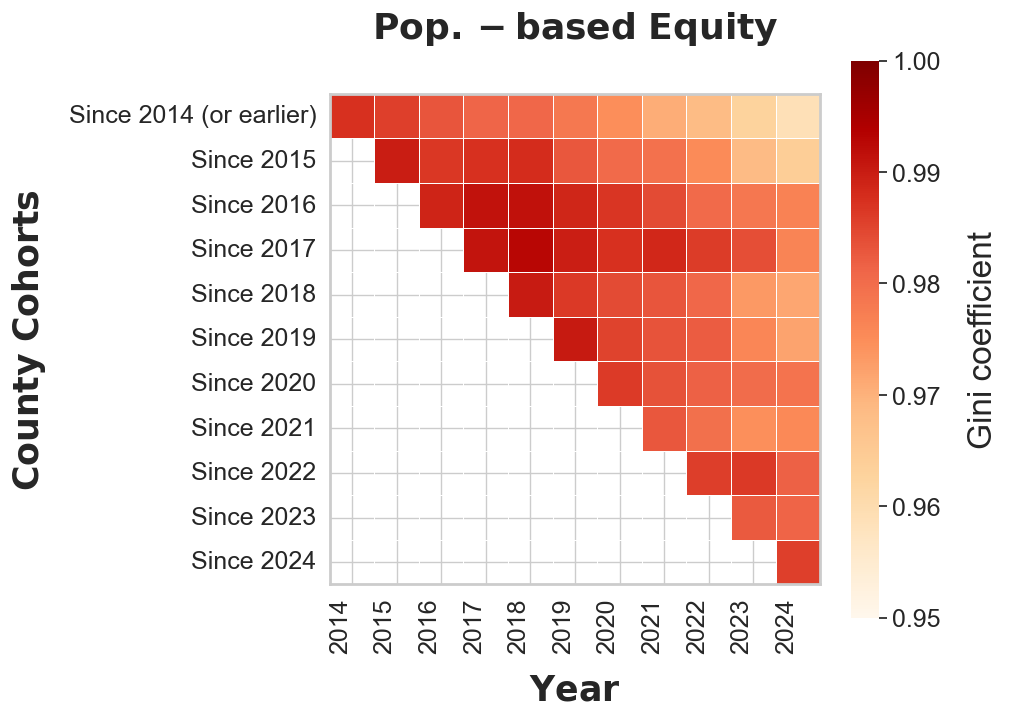

In [6]:
combined_medians_all = calculate_cohort_medians(final_gdf_all_evse)
plot_heatmap(combined_medians_all,designed_map='OrRd')

## DC EVSE

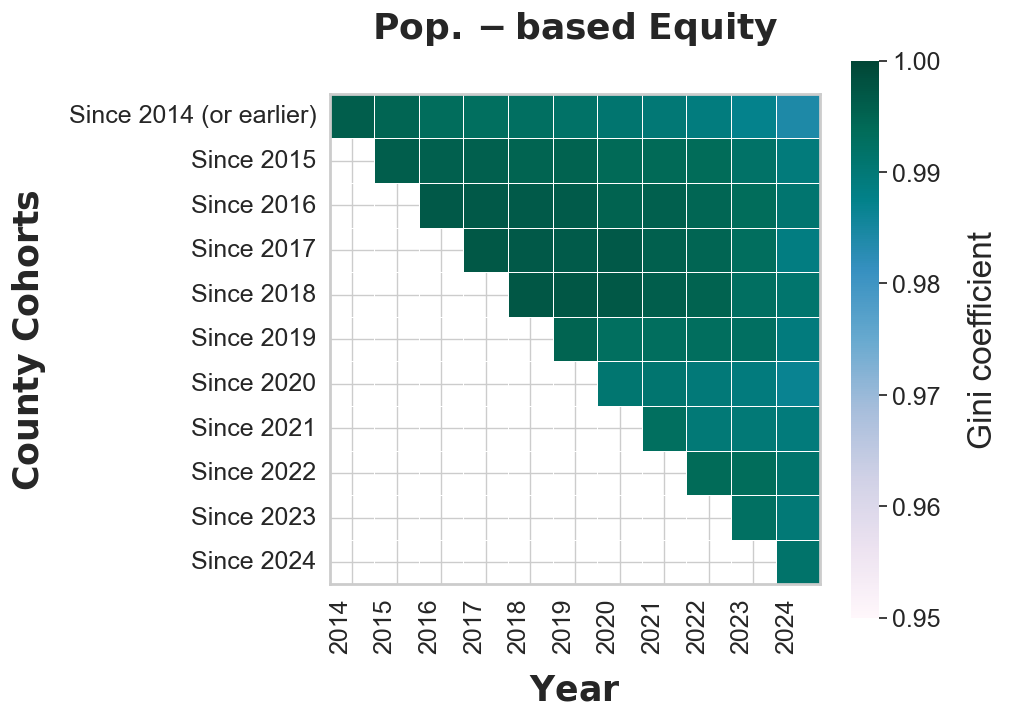

In [7]:
combined_medians_dc = calculate_cohort_medians(final_gdf_dc_evse) 
plot_heatmap(combined_medians_dc,designed_map='PuBuGn')

## L2 EVSE

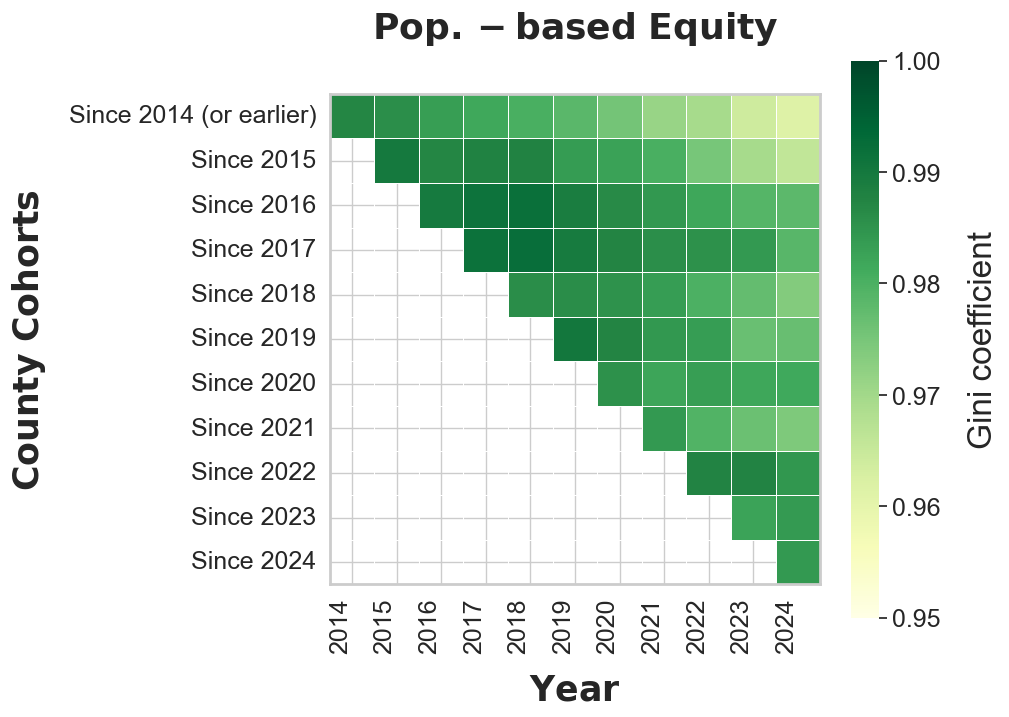

In [8]:
combined_medians_l2 = calculate_cohort_medians(final_gdf_l2_evse)
plot_heatmap(combined_medians_l2,designed_map='YlGn')